In [ ]:
#sin predictor model from hw3
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models

# Step 1: Generate example data
num_train_examples = 20000
sequence_length = 8

batch_size = 64
num_epochs = 25
val_split = 0.2

rng = np.random.default_rng(2024)

In [54]:
# Generate random frequencies for sine waves
# we'll use 1.0 as the maximum Nyquist frequency and 0 = constant
frequencies = rng.uniform(0.02, 0.2, size=num_train_examples)
phase_offsets = rng.uniform(0.0, 2*np.pi, size=num_train_examples)
sequences = np.zeros((num_train_examples, sequence_length))

# Generate sine waves
for i in range(num_train_examples):
    sequences[i] = np.sin(2*np.pi*frequencies[i]* np.arange(sequence_length) + phase_offsets[i])

# Split sequences into input (first <sequence_length-1> elements) and labels (sequence_length>'th element)
x_train = sequences[:, :sequence_length-1]
y_train = sequences[:, sequence_length-1]


In [55]:
# Build the model
model = models.Sequential([
  layers.InputLayer(input_shape=x_train.shape[1:]), 
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(1)  # Single neuron for regression
])

# Compile the model
steps_per_epoch = int((1.0-val_split)*num_train_examples / batch_size)
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-2, steps_per_epoch*num_epochs)
  
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule), # use tf.keras.optimizers.Adam on Intel / NVidia GPU
              loss='mean_squared_error'
             )

In [56]:
# Train the model
train_hist = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=val_split)

Epoch 1/25
250/250 [==============================] - 1s 4ms/step - loss: 0.0738 - val_loss: 0.1677
Epoch 2/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0162 - val_loss: 0.0137
Epoch 3/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0153 - val_loss: 0.0081
Epoch 4/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0148 - val_loss: 0.0040
Epoch 5/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0135 - val_loss: 0.0017
Epoch 6/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0119 - val_loss: 0.0038
Epoch 7/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0106 - val_loss: 0.0038
Epoch 8/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0097 - val_loss: 0.0025
Epoch 9/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0104 - val_loss: 0.0025
Epoch 10/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0020

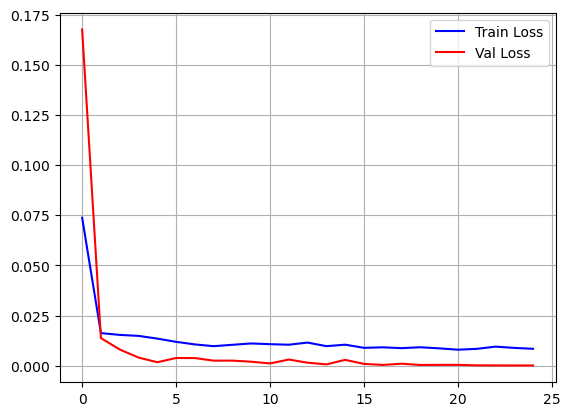

In [57]:
plt.plot(train_hist.epoch, train_hist.history['loss'], 'b-', label='Train Loss')
plt.plot(train_hist.epoch, train_hist.history['val_loss'], 'r-', label='Val Loss')
        

        
plt.legend()
plt.grid(True)

In [58]:
loss = model.evaluate(x_train, y_train)
print("Final training loss:", loss)

625/625 [==============================] - 1s 1ms/step - loss: 8.0267e-05
Final training loss: 8.026706927921623e-05


625/625 [==============================] - 1s 1ms/step


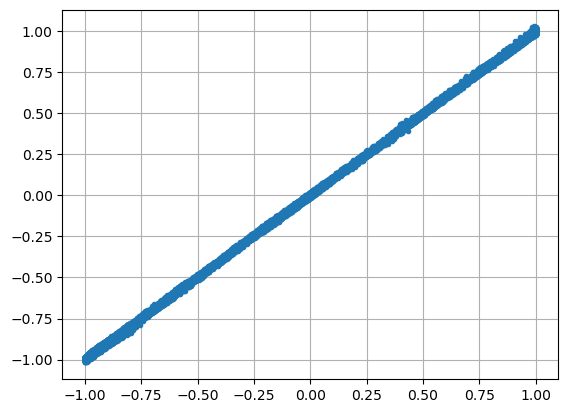

In [59]:
y_pred = model.predict(x_train)
plt.plot(y_train, y_pred, '.')
plt.grid(True)

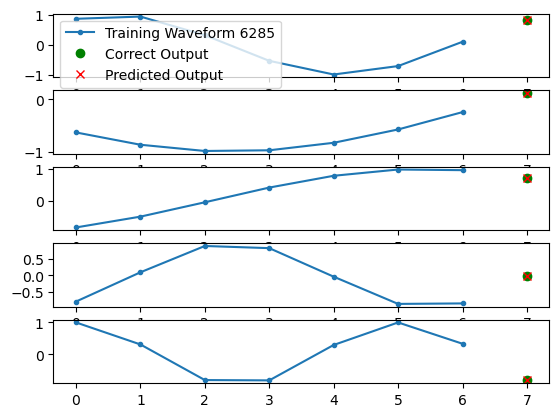

In [60]:
num_to_plot = 5
for i in range(5):
  plt.subplot(num_to_plot,1,i+1)
  index = rng.integers(low=0, high=num_train_examples)
  plt.plot(np.arange(sequence_length-1), x_train[i,:], '.-', 
           sequence_length-1, y_train[i], 'go',
           sequence_length-1, y_pred[i], 'rx'
          )
  if i == 0:
    # the legend obscures the data, so just show it once
    plt.legend([f"Training Waveform {index}", "Correct Output", "Predicted Output"])

In [61]:
model.save("sin_predictor.h5")

In [62]:
# Load the trained Keras model
model = tf.keras.models.load_model("sin_predictor.h5")

num_calibration_steps = 100  # Increase calibration steps for better accuracy

# Apply full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Generate representative dataset for proper quantization
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        data = np.random.uniform(-1, 1, size=(1, 7)).astype(np.float32)  # Adjust to match model input range
        yield [data]

converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] 

# Ensure 8-bit integer inputs/outputs
converter.inference_input_type = tf.int8  
converter.inference_output_type = tf.int8  

# Convert and save model
tflite_quant_model = converter.convert()
tflite_model_filename = "sin_predictor.tflite"

with open(tflite_model_filename, "wb") as fpo:
    fpo.write(tflite_quant_model)

print(f"Saved quantized TFLite model as {tflite_model_filename}")


INFO:tensorflow:Assets written to: C:\Users\legon\AppData\Local\Temp\tmpsdv4r6ti\assets


INFO:tensorflow:Assets written to: C:\Users\legon\AppData\Local\Temp\tmpsdv4r6ti\assets


Saved quantized TFLite model as sin_predictor.tflite


c:\Users\legon\miniconda3\envs\IOTenv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [65]:
import numpy as np

# Load trained model
model = tf.keras.models.load_model("sin_predictor.h5")

# Define test input (all zeros)
test_input = np.array([[1,2,3,5,3,2,1]], dtype=np.float32)

# Make prediction
prediction = model.predict(test_input)
print("Model Prediction:", prediction)

1/1 [==============================] - 0s 54ms/step
Model Prediction: [[0.36042976]]
